In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
import numpy as np

launch.json used to generate epoch-wise pkls

In [ ]:
# {
#     "version": "0.2.0",
#     "configurations": [
#    	 {
#    		 "name": "Run with argument",
#    		 "type": "python",
#    		 "request": "launch",
#    		 "program": "${file}",
#    		 "console": "integratedTerminal",
#    		 "cwd": "${workspaceFolder}/tools",
#    		 "env": {"CUDA_VISIBLE_DEVICES": "1"},
#    		 "args": ["--cfg_file" ,
#            		 "cfgs/kitti_models/pv_rcnn_ssl_60.yaml",
#            		 "--split",
#            		 "train_0.01_1",
#            		 "--batch_size",
#            		 "8",
#            		 "--ckpt_save_interval",
#            		 "20",
#            		 "--repeat",
#            		 "5",
#            		 "--fix_random_seed",
#            		 "--extra_tag",
#            		 "tsne_3diou_secndstage_ckpt60_snapshot_new_ulbloader",
#            		 "--dbinfos",
#            		 "kitti_dbinfos_train_0.01_1_37.pkl",
#                  "--epochs", // for repeat 5, bsz 8: to cover 3769 ulb frames needs ~21 epochs
#                  "100",
#                  "--ckpt",
#                  "/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn_ssl_60/ckpts_3diou_split_1_1_0fbd0d1/ckpt/checkpoint_epoch_60.pth",
#                 "--set",
#                  "MODEL.STORE_SCORES_IN_PKL",
#                 "True"
#    		 ],
#    	 }
#     ]
# }


Script to read epoch wise pkls, combine and store as snapshot_pl_data


In [24]:
import os
import pickle
# Directory containing the pickle files
pickle_dir = "/mnt/data/adat01/adv_OpenPCDet/output/kitti_models/pv_rcnn_ssl_60/Tsne_objectness_pkl_scores_28be05f"
# List all pickle files in the directory
pickle_files = [file for file in os.listdir(pickle_dir) if file.endswith(".pkl")]

# Initialize an empty dictionary to store aggregated data
snapshot_pl_data = {}

# Iterate over each pickle file
for file in pickle_files:
    # Load the pickle file
    with open(os.path.join(pickle_dir, file), "rb") as f:
        data = pickle.load(f)
    # Combine the data from the current file with the aggregated data
    for key, value in data.items():
        if key not in snapshot_pl_data:
            snapshot_pl_data[key] = []
        snapshot_pl_data[key].extend(value)



In [25]:
snapshot_pl_data.keys()

dict_keys(['iou_roi_pl', 'iou_roi_gt', 'obj_scores', 'gt_boxes', 'assigned_gt_inds', 'assigned_iou_class', 'roi_scores', 'num_points_in_roi', 'class_labels', 'iteration', 'shared_features', 'frame_id', 'shared_features_gt', 'instance_idx', 'labeled_mask', 'unlabeled_mask', 'ori_gt_boxes', 'IOU_assigned_label', 'GT_labels', 'gt_obj_scores'])

In [26]:
print(np.array(snapshot_pl_data['labeled_mask']).sum())
print(np.array(snapshot_pl_data['unlabeled_mask']).sum())


0
2319


In [34]:
pl_boxes = np.concatenate(snapshot_pl_data['gt_boxes']) #11161,8
gt_boxes = np.concatenate(snapshot_pl_data['ori_gt_boxes'])  #7180,8


(7180, 8)

In [44]:
snapshot_pl_data['ori_gt_boxes'][4]

tensor([[12.7726,  8.1181, -0.9316,  3.3669,  1.4794,  1.4284, -2.8038,  0.0000],
        [11.8502,  5.2601, -0.9041,  3.9688,  1.6630,  1.4284, -2.9538,  0.0000],
        [21.2593,  1.0580, -0.5205,  1.8569,  0.6428,  1.8059,  0.3262,  2.0000],
        [35.4265, 14.6907, -0.7577,  4.4075,  1.3569,  1.4080, -2.8438,  0.0000]])

In [45]:
snapshot_pl_data['gt_boxes'][4]

tensor([[12.4105,  1.6959, -0.9147,  3.7878,  1.5778,  1.4414,  3.0683,  0.0000],
        [14.3630,  4.0331, -0.9722,  3.7082,  1.4651,  1.3757,  3.2073,  0.0000],
        [20.1666, -4.8669, -0.4613,  1.7454,  0.5749,  1.7262,  6.4373,  2.0000],
        [11.6379,  7.9635, -0.7214,  0.6957,  0.6236,  1.6445,  2.8843,  1.0000]])

In [12]:
for i in range(len(snapshot_pl_data['IOU_assigned_label'])):
    snapshot_pl_data['IOU_assigned_label'][i] = snapshot_pl_data['IOU_assigned_label'][i].cpu()

iou_assigned_label = np.concatenate(snapshot_pl_data['IOU_assigned_label'])
iou_assigned_label.shape

(7180,)

In [13]:
pl_labels = np.concatenate(snapshot_pl_data['gt_boxes'])
pl_labels = pl_labels[:, -1]
pl_labels.shape

(7180,)

In [14]:
sh_gt_array = np.concatenate(snapshot_pl_data['shared_features_gt'])
sh_gt_array.shape

(7180, 256)

In [ ]:
import torch

# Initialize an empty list to store concatenated tensors
labeled_gt_obj_scores_list = []
unlabeled_gt_obj_scores_list = []

labeled_gt_classes_list = []
unlabeled_gt_classes_list = []

labeled_gt_sh_ft_list = []
unlabeled_gt_sh_ft_list = []

# Iterate over the labeled mask and corresponding tensors
for mask, tensor in zip(snapshot_pl_data['labeled_mask'], snapshot_pl_data['gt_obj_scores']):
    if mask == 1:
        labeled_gt_obj_scores_list.append(tensor)
    if mask == 0:
        unlabeled_gt_obj_scores_list.append(tensor)

for mask, tensor in zip(snapshot_pl_data['labeled_mask'], snapshot_pl_data['ori_gt_boxes']):
    if mask == 1:
        labeled_gt_classes_list.append(tensor[:,-1])
    if mask == 0:
        unlabeled_gt_classes_list.append(tensor[:,-1])


for mask, tensor in zip(snapshot_pl_data['labeled_mask'], snapshot_pl_data['shared_features_gt']):
    if mask == 1:
        labeled_gt_sh_ft_list.append(tensor)
    if mask == 0:
        unlabeled_gt_sh_ft_list.append(tensor)


In [ ]:
import numpy as np

lbl_gt_obj_scores= np.concatenate(labeled_gt_obj_scores_list)
lbl_gt_classes = np.concatenate(labeled_gt_classes_list)
lbl_gt_sh_ft = np.concatenate(labeled_gt_sh_ft_list)

ulb_gt_obj_scores= np.concatenate(unlabeled_gt_obj_scores_list)
ulb_gt_classes = np.concatenate(unlabeled_gt_classes_list)
ulb_gt_sh_ft = np.concatenate(unlabeled_gt_sh_ft_list)

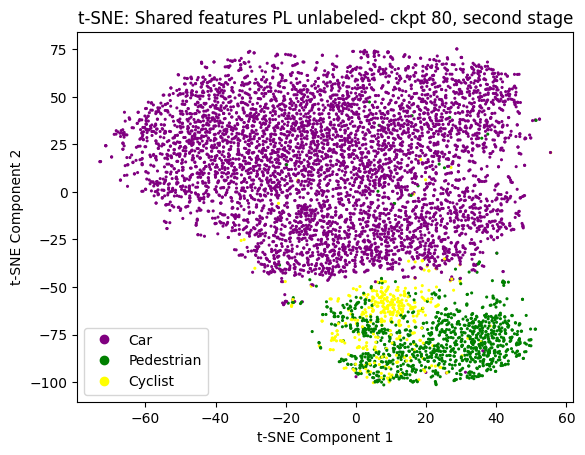

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
iou_labels = iou_assigned_label

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create custom colormap
colors = ['purple', 'green', 'yellow']
cmap = ListedColormap(colors)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap=cmap, s=1.5)

# Add legend
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = "t-SNE: Shared features PL unlabeled- ckpt 80, second stage"
plt.title(title)

plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

# # Create a sample dataset
# x = ulb_gt_sh_ft
# y = ulb_gt_classes.astype(int)
# conf_scores = ulb_gt_obj_scores
# # Normalize the features
# scaler = StandardScaler()
# x_normalized = scaler.fit_transform(x)

# # Perform t-SNE on normalized features
# tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
# x_tsne = tsne.fit_transform(x_normalized)

# # Create a scatter plot with colored points based on labels
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=5)
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# title = f"t-SNE: Shared features GT Unlabeled,second stage-ckpt60, {np.unique(ulb_frame_ids).shape[0]} scenes"
# plt.title(title)
# # Add legend
# class_names = ['Car', 'Pedestrian', 'Cyclist']
# handles, _ = scatter.legend_elements(num=len(class_names))
# legend = plt.legend(handles, class_names, loc='upper right')

# # Add a box showing occurrences of each class
# class_counts = np.bincount(y)
# total_count = np.sum(class_counts)
# class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count} instances" for class_name, count in zip(class_names, class_counts)]
# occurrences_text = '\n'.join(class_counts_str)
# plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# plt.show()

In [ ]:
def get_objectness_tp_fp(x, y, conf_scores,thresh):

    x = x
    y = y.astype(int)

    car_mask = y==0
    ped_mask = y==1
    cyc_mask = y==2

    conf_scores_car = conf_scores[car_mask]
    conf_scores_ped = conf_scores[ped_mask]
    conf_scores_cyc = conf_scores[cyc_mask]

    conf_scores_car = conf_scores_car>= thresh[0]
    conf_scores_ped = conf_scores_ped>= thresh[1]
    conf_scores_cyc = conf_scores_cyc>=thresh[2]
    conf_scores_car = conf_scores_car.astype(int)
    conf_scores_ped = conf_scores_ped.astype(int)
    conf_scores_cyc = conf_scores_cyc.astype(int)

    shape_diff = tuple((target - current) for target, current in zip(conf_scores.shape, conf_scores_car.shape))
    padding = tuple((0, diff) for diff in shape_diff)
    conf_scores_car_padded =  np.pad(conf_scores_car, padding, mode='constant', constant_values=-1)
    shape_diff = tuple((target - current) for target, current in zip(conf_scores.shape, conf_scores_ped.shape))
    padding = tuple((0, diff) for diff in shape_diff)
    conf_scores_ped_padded =  np.pad(conf_scores_ped, padding, mode='constant', constant_values=-1)
    shape_diff = tuple((target - current) for target, current in zip(conf_scores.shape, conf_scores_cyc.shape))
    padding = tuple((0, diff) for diff in shape_diff)
    conf_scores_cyc_padded =  np.pad(conf_scores_cyc, padding, mode='constant', constant_values=-1)

    tsne_colors = {'0': conf_scores_car_padded,  '1': conf_scores_ped_padded, '2': conf_scores_cyc_padded}

    return tsne_colors

In [ ]:
tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)


In [ ]:
marker_dict = {0:"s",1:"o",2:"d"}
markers = [marker_dict[pl_labels[i]] for i in range(len(pl_labels))]


In [23]:
gt_boxes = np.array(snapshot_pl_data['gt_boxes'])
pl_boxes = np.array(snapshot_pl_data['pl_boxes'])


AttributeError: 'list' object has no attribute 'shape'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


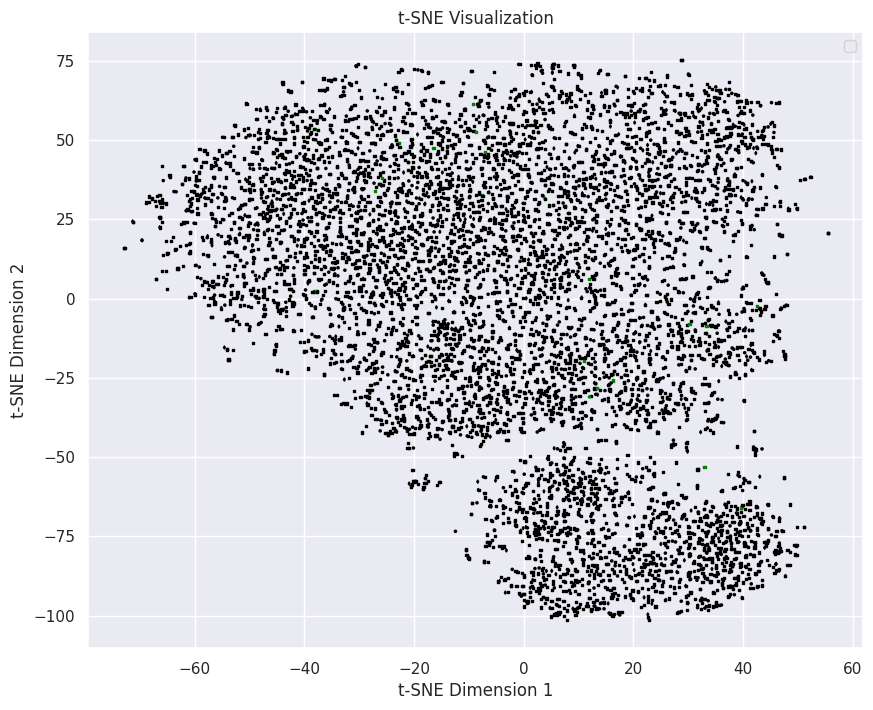

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
conf_scores = iou_assigned_label
marker_dict = {0:"s",1:"o",2:"d"}
markers = [marker_dict[y[i]] for i in range(len(y))]
comparison_result = [-1 if score == -1 else (1 if label == score else 0) for label, score in zip(y, conf_scores)]
colors = ['black' if result == -1 else ('red' if result == 0 else 'green') for result in comparison_result]

# gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
# tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

import numpy as np

# Get the indices that would sort y in ascending order
sorted_indices = np.argsort(y)
sorted_y = y[sorted_indices]
sorted_x_tsne = x_tsne[sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

idx_0_last = np.where(sorted_y == 0)[0][-1]
idx_1_first = np.where(sorted_y == 1)[0][0]
idx_1_last = np.where(sorted_y == 1)[0][-1]+1

sns.set(style='darkgrid')



# Plot t-SNE with markers and colors
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:idx_1_first, 0], x_tsne[:idx_1_first, 1], marker='s', color=sorted_colors[:idx_1_first],s=2.5)
plt.scatter(x_tsne[idx_1_first:idx_1_last, 0], x_tsne[idx_1_first:idx_1_last, 1], marker='o', color=sorted_colors[idx_1_first:idx_1_last],s=2.5)
plt.scatter(x_tsne[idx_1_last:, 0], x_tsne[idx_1_last:, 1], marker='d', color=sorted_colors[idx_1_last:],s=2.5)

plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()
# class_names = ['Car', 'Pedestrian', 'Cyclist']
# # Plot dummy points with markers
# for marker, class_name in zip(markers, class_names):
#     plt.scatter([], [], marker=marker, color='white', label=class_name,edgecolor = 'black')  # Set color to white
# # Create legend
# plt.legend(title='Class Markers', loc='lower right')  # Move legend to bottom right



# # Show plot
# plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_gt_sh_ft
y = ulb_gt_classes.astype(int)
conf_scores = ulb_gt_obj_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

sns.set(style='darkgrid')

# Define marker styles
markers = ["s", "o", "d"]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Creating 3 subplots side by side
class_names = ['Car', 'Pedestrian', 'Cyclist']

for start, ax in enumerate(axs):
    start_key = str(start)
    # Plot t-SNE components
    sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], marker=markers[start], s=20, edgecolor='black',
                    hue=tsne_colors[start_key], palette={1: 'green', 0: 'red', -1 : 'white'}, legend=False, ax=ax)
    # Set labels and title for each subplot
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_title(f"ULB features with FG/BG mask for {class_names[start]}")

    # Plot dummy points with markers
    for marker, class_name in zip(markers, class_names):
        ax.scatter([], [], marker=marker, color='white', label=class_name, edgecolor='black')  # Set color to white

    # Create legend
    ax.legend(title='Class Markers', loc='lower right')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_gt_sh_ft
y = ulb_gt_classes.astype(int)
conf_scores = ulb_gt_obj_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

# Set seaborn style
sns.set(style='whitegrid')

# Define marker styles
markers = ["s", "o", "d"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Plot t-SNE components for each key value
for key, ax in zip(tsne_colors.keys(), axes):
        sns.scatterplot(
            x=x_tsne[:, 0],
            y=x_tsne[:, 1],
            marker=markers[int(key)],
            s=30,
            # edgecolor='',
            hue=tsne_colors,
            palette={1: 'green', 0: 'red', -1 : 'white'},  # Bind colors to True and False
            legend='full',  # Show legend
            ax=ax  # Set the current subplot
        )
    # Set labels and title for each subplot
        ax.set_xlabel('t-SNE Component 1')
        ax.set_ylabel('t-SNE Component 2')
        ax.set_title(f"Key Value: {key}")

# Plot dummy points with markers for class names on the last subplot
class_names = ['Car', 'Pedestrian', 'Cyclist']
for marker, class_name in zip(markers, class_names):
    axes[-1].scatter([], [], marker=marker, color='white', label=class_name, edgecolor='black')  # Set color to white

# Create legend for class names on the last subplot
axes[-1].legend(title='Class Markers', loc='upper right')  # Move legend to bottom right

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
x_tsne.shape

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = ulb_gt_sh_ft
y = ulb_gt_classes.astype(int)
conf_scores = ulb_gt_obj_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

# Set seaborn style
sns.set(style='whitegrid')

# Define marker styles
markers = ["s", "o", "d"]

plt.figure(figsize=(10, 8))

# Plot t-SNE components
for start, marker in enumerate(markers):
    key = str(start)
    if tsne_colors[key] != -1:  # Check if tsne_colors[key] is not -1
        sns.scatterplot(
            x=x_tsne[:, 0],
            y=x_tsne[:, 1],
            marker=marker,
            s=30,
            # edgecolor='',
            hue=tsne_colors[key],
            palette={ 1: 'green', 0: 'red'},  # Bind colors to True and False
            legend='full'  # Show legend
        )

# Set labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = f"TP/FP masked Tsne for ulb_GT_objectness, second_stage, {np.unique(ulb_frame_ids).shape[0]} scenes"
plt.title(title)

# Plot dummy points with markers for class names
class_names = ['Car', 'Pedestrian', 'Cyclist']
for marker, class_name in zip(markers, class_names):
    plt.scatter([], [], marker=marker, color='white', label=class_name, edgecolor='black')  # Set color to white

# Create legend for class names
plt.legend(title='Class Markers', loc='upper right')  # Move legend to bottom right

class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count} instances" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.02, 0.02, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))
# Show plot
plt.show()


In [ ]:
# def get_max_iou(anchors, gt_boxes, gt_classes, matched_threshold=0.6):
#     num_anchors = anchors.shape[0]
#     num_gts = gt_boxes.shape[0]

#     ious = torch.zeros((num_anchors,), dtype=torch.float, device=anchors.device)
#     labels = torch.ones((num_anchors,), dtype=torch.int64, device=anchors.device) * -1
#     gt_to_anchor_max = torch.zeros((num_gts,), dtype=torch.float, device=anchors.device)

#     if len(gt_boxes) > 0 and anchors.shape[0] > 0:
#         anchor_by_gt_overlap = iou3d_nms_utils.boxes_iou3d_gpu(anchors[:, 0:7], gt_boxes[:, 0:7])
#         gt_to_anchor_max = anchor_by_gt_overlap.max(dim=0)[0]
#         anchor_to_gt_argmax = anchor_by_gt_overlap.argmax(dim=1)
#         anchor_to_gt_max = anchor_by_gt_overlap[torch.arange(num_anchors, device=anchors.device), anchor_to_gt_argmax]

#         pos_inds = anchor_to_gt_max >= matched_threshold
#         gt_inds_over_thresh = anchor_to_gt_argmax[pos_inds]
#         labels[pos_inds] = gt_classes[gt_inds_over_thresh]
#         ious[:] = anchor_to_gt_max

#     return ious, labels, gt_to_anchor_max

In [ ]:
labeled_mask_np = np.array(ckpt60_snapshot_data['labeled_mask'])
frame_id_np = np.array(ckpt60_snapshot_data['frame_id'])
lb_frame_ids = frame_id_np[labeled_mask_np == 1]
vals,indices = np.unique(lb_frame_ids,return_index=True)
print(len(np.sort(indices)))
unique_lb_frame_mask = np.sort(indices)

In [ ]:
np.array(ckpt60_snapshot_data['shared_features_gt']).shape

In [ ]:
lb_obj_scores = np.array(ckpt60_snapshot_data['obj_scores'])
lb_obj_scores = lb_obj_scores[unique_lb_frame_mask]

lb_shared_features_gt = np.array(ckpt60_snapshot_data['shared_features_gt'])
lb_shared_features_gt = lb_shared_features_gt[unique_lb_frame_mask]
print(len(lb_shared_features_gt))

lb_ori_gt_boxes = np.array(ckpt60_snapshot_data['ori_gt_boxes'])
lb_ori_gt_classes = lb_ori_gt_boxes[:,-1]
lb_ori_gt_classes = lb_ori_gt_classes[unique_lb_frame_mask]
print(len(lb_ori_gt_classes))

lb_gt_conf_scores = np.array(ckpt60_snapshot_data['gt_obj_scores'])
lb_gt_conf_scores = lb_gt_conf_scores[unique_lb_frame_mask]
print(len(lb_gt_conf_scores))

In [ ]:
# util function for getting TP/FP for objectness


def get_objectness_tp_fp(x_tsne, y_tsne, conf_scores,thresh):
    unique_classes = np.unique(y_tsne)
    x_tsne_dict = {}
    y_pred_dict = {}

    for class_label in unique_classes:
        class_mask = y_tsne == class_label
        x_tsne_class = np.zeros_like(x_tsne)
        x_tsne_class[class_mask] = x_tsne[class_mask]
        x_tsne_dict[class_label] = x_tsne_class

        tmp = np.zeros_like(conf_scores)
        tmp = conf_scores * class_mask 
        tmp = tmp >= gt_iou_thresh[class_label]
        y_pred_dict[class_label] = tmp

    return x_tsne_dict, y_pred_dict

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = lb_shared_features_gt
y = lb_ori_gt_classes.astype(int)
conf_scores = lb_gt_conf_scores
gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
x_tsne_dict, y_tsne_dict = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)
tp_fp_labels = y_tsne_dict[0] + y_tsne_dict[1] + y_tsne_dict[2]

# Set seaborn style
sns.set(style='darkgrid')

# Define marker styles
markers = ["s", "o", "d"]

plt.figure(figsize=(10, 8))

# Plot t-SNE components
for start, marker in enumerate(markers):
    sns.scatterplot(
        x=x_tsne_dict[start][:, 0],
        y=x_tsne_dict[start][:, 1],
        marker=marker,
        s=30,
        edgecolor='black',
        hue=tp_fp_labels,
        palette={True: 'green', False: 'red'},  # Bind colors to True and False
        legend='full'  # Show legend
    )

# Set labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = f"TP/FP masked Tsne for lb_GT_objectness, second_stage, {np.unique(lb_frame_ids).shape[0]} scenes"
plt.title(title)

# Plot dummy points with markers for class names
class_names = ['Car', 'Pedestrian', 'Cyclist']
for marker, class_name in zip(markers, class_names):
    plt.scatter([], [], marker=marker, color='white', label=class_name, edgecolor='black')  # Set color to white

# Create legend for class names
plt.legend(title='Class Markers', loc='lower right')  # Move legend to bottom right

# Create separate legend for True (TP) and False (FP)
plt.legend(['True (TP)', 'False (FP)'], loc='upper right')

class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count} instances" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.02, 0.02, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))
# Show plot
plt.show()



In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# # Plot the first t-SNE plot
# scatter1 = axs[0].scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
# axs[0].set_xlabel('t-SNE Component 1')
# axs[0].set_ylabel('t-SNE Component 2')
# axs[0].set_title('t-SNE : Shared features ROI, end of Pretrain, 3dioumatch-org')

# # Plot the second t-SNE plot
# scatter2 = axs[1].scatter(x_tsne_gt[:, 0], x_tsne_gt[:, 1], c=y_gt, cmap='viridis', s=1.5)
# axs[1].set_xlabel('t-SNE Component 1')
# axs[1].set_ylabel('t-SNE Component 2')
# axs[1].set_title('t-SNE : Shared features GT, end of Pretrain, 3dioumatch-org')

# class_counts = np.bincount(y)
# total_count = np.sum(class_counts)
# class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
# occurrences_text = '\n'.join(class_counts_str)
# plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))


# class_counts = np.bincount(y_gt)
# total_count = np.sum(class_counts)
# class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
# occurrences_text = '\n'.join(class_counts_str)
# plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# # Set equal aspect ratio for both plots
# axs[0].axis('equal')
# axs[1].axis('equal')

# plt.show()